In [1]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 144 kB 41.4 MB/s 
     |████████████████████████████████| 181 kB 41.0 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=2a7f2b3c70a67259b24f017860c63a0eaec602e5dd51caf82c8be92f82001a5a
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import wandb
from wandb.keras import WandbCallback

In [3]:
wandb.init(project='17 Flowers')

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
train_dataset_path = "/content/drive/MyDrive/Dataset/Flowers/Train"
width = height = 224
batchSize = 32

idg = ImageDataGenerator(
    rescale=1./255,

    # Augmentation
    horizontal_flip=True,
    brightness_range=(0.7, 1.3),
    rotation_range=15,
    zoom_range=0.2,
    shear_range=0.2,

    validation_split=0.2
)

train_data = idg.flow_from_directory(
    train_dataset_path,
    target_size=(width, height),
    class_mode="categorical",
    batch_size=batchSize,
    subset="training"
)

val_data = idg.flow_from_directory(
    train_dataset_path,
    target_size=(width, height),
    class_mode="categorical",
    batch_size=batchSize,
    subset="validation"
)

Found 884 images belonging to 17 classes.
Found 204 images belonging to 17 classes.


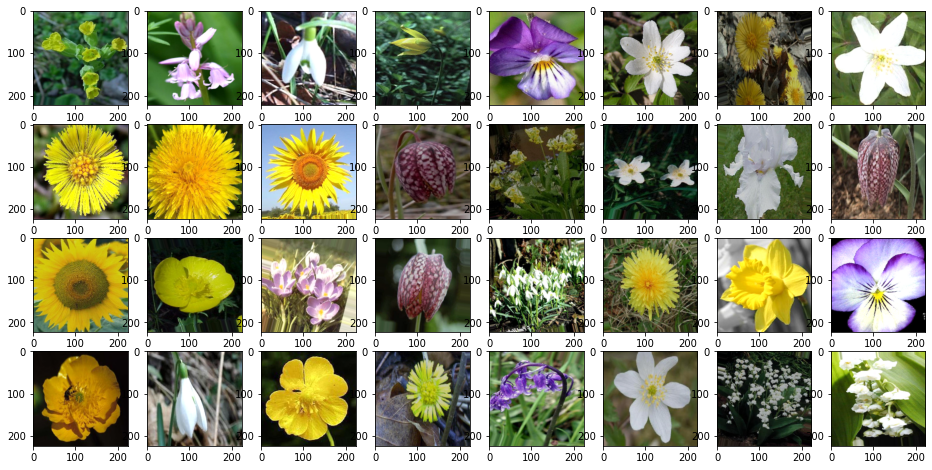

In [5]:
some_images = next(train_data)
X = some_images[0]
Y = some_images[1]

plt.figure(figsize=(16, 8))

for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(X[i])

Model

In [6]:
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(width, height, 3),
    pooling='avg'
)

for layer in base_model.layers[:-3]:
    layer.trainable = False

model = tf.keras.models.Sequential([
    base_model,

    # layers.Flatten(),
    # layers.Dense(1024, activation="relu"),

    layers.Dropout(0.3),  
    layers.Dense(17, activation="softmax")
])

9420800/9406464 [==============================] - 0s 0us/step


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 17)                21777     
                                                                 
Total params: 2,279,761
Trainable params: 24,337
Non-trainable params: 2,255,424
_________________________________________________________________


In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=["accuracy"]
)

In [9]:
model.fit(train_data, validation_data=val_data, epochs=20, callbacks=[WandbCallback()])

Epoch 1/20
28/28 [==============================] - 311s 11s/step - loss: 2.2370 - accuracy: 0.3337 - val_loss: 1.5394 - val_accuracy: 0.5735 - _timestamp: 1648215475.0000 - _runtime: 429.0000
Epoch 2/20
28/28 [==============================] - 26s 917ms/step - loss: 1.1017 - accuracy: 0.7070 - val_loss: 1.0260 - val_accuracy: 0.6863 - _timestamp: 1648215501.0000 - _runtime: 455.0000
Epoch 3/20
28/28 [==============================] - 26s 937ms/step - loss: 0.7306 - accuracy: 0.8111 - val_loss: 0.8656 - val_accuracy: 0.7451 - _timestamp: 1648215527.0000 - _runtime: 481.0000
Epoch 4/20
28/28 [==============================] - 26s 933ms/step - loss: 0.5938 - accuracy: 0.8394 - val_loss: 0.6985 - val_accuracy: 0.7598 - _timestamp: 1648215553.0000 - _runtime: 507.0000
Epoch 5/20
28/28 [==============================] - 26s 931ms/step - loss: 0.4284 - accuracy: 0.9005 - val_loss: 0.6257 - val_accuracy: 0.8039 - _timestamp: 1648215579.0000 - _runtime: 533.0000
Epoch 6/20
28/28 [=============

Save

In [10]:
model.save('17Flowers_model.h5')

Test

In [11]:
test_dataset_path = "/content/drive/MyDrive/Dataset/Flowers/Test"
width = height = 224
batchSize = 32

idg = ImageDataGenerator(
    rescale=1./255
)

test_data = idg.flow_from_directory(
    test_dataset_path,
    target_size=(width, height),
    class_mode="categorical",
    batch_size=batchSize
)

Found 272 images belonging to 17 classes.


In [12]:
model.evaluate(test_data)

9/9 [==============================] - 65s 8s/step - loss: 0.4707 - accuracy: 0.8493


[0.4707062244415283, 0.8492646813392639]

Inference

In [14]:
image = cv2.imread('/content/download.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (width, height))
image = image / 255.0

image = image.reshape(1, width, height, 3)

start_time = time.time()
result = model.predict(image)
end_time = time.time()

print(np.argmax(result))
print(end_time - start_time)

9
0.06297731399536133
